In [2]:
#code is used from these 3 repositories, have a look at them on GitHub or access the files from colab
!git clone https://github.com/PeterWang512/FALdetector
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!git clone https://github.com/Kwanss/PCLNet

Cloning into 'FALdetector'...
Cloning into 'flownet2-pytorch'...
Cloning into 'PCLNet'...


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 25 10:32:09 2020

@author: peter fazekas
"""
#import necessary modules and append paths 

import os
import csv
import pickle
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/FALdetector/networks/")
sys.path.append("/content/FALdetector/")
from drn_seg import DRNSeg
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss,BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
sys.path.append("/content/flownet2-pytorch/")
import losses
from losses import MultiScale,EPE
sys.path.append("/content/PCLNet/Losses/")
sys.path.append("/content/PCLNet/models/")
from utils.tools import *
from utils.visualize import *
import pandas as pd
import numpy as np
import torch.nn as nn
# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from torchsummary import summary

ModuleNotFoundError: No module named 'drn_seg'

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!unzip /mydrive/nofakes/flow_pred_data/modified.zip -d modif
!unzip /mydrive/nofakes/flow_pred_data/reference.zip -d ref
!unzip /mydrive/nofakes/flow_pred_data/local_weight.zip

ModuleNotFoundError: No module named 'google.colab'

In [5]:
pathM =r"/content/modif"
path =r"/content/ref"

#if you guys can come up with a more efficient way to do this go ahead.
height, width = 400, 400
#variable to control how many training examples to import
train_size = 5
filenames = []
   
#Redo this part.... it doesnt import training images in order, I have printed out the filenames imported for convenience
# 23/01/21 added augmentation, convert PNG to JPG, and read files in order 

def anticlockwise_rotation(img):
    angle = random.randint(0,180)
    return rotate(img, angle)

def clockwise_rotation(img):
    angle = random.randint(0,180)
    return rotate(img, -angle)

def h_flip(img):
    return  np.fliplr(img)

def v_flip(img):
    return np.flipud(img)

def add_noise(img):
    return random_noise(img)

def blur_image(img):
    return cv2.GaussianBlur(img, (5,5),0)

transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                   'blurring image':blur_image
                 }                #use dictionary to store names of functions 
    

def createTrain(path, n_images):
    
    arr=[]
    count = 0
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
          #make sure to change to correct image format .jpg or .png etc...
            if '.png' in name:
                
                #print(name)
                img = Image.open(r"" + path + "/" + str(name))
                img.save(r"" + path + "/" str(name) + '.jpg')
                
            if '.jpg' in name:
                
                #print(name)
                img = cv2.imread(r"" + path + "/" + str(name), flag = cv2.IMREAD_COLOR)
                filenames.append(path + "/" + str(name))
                
                #keep image dimensions at 400 for now, the following is image interpolation
                img_height, img_width, _ = img.shape
                
                #for the case where we shrink 
                if img_height > height & img_width > width:
                    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
                    
                #for the case where we don't shrink   
                else: img = cv2.resize(img, (width, height), interpolation = cv2.INTER_CUBIC)
                    
                arr.append(img)
                
                #choose random number of transformation to apply on the image
                trans_count = random.randint(1, len(transformations)) 
                count_trans = 0
    
                while count_trans <= trans_count:
            
                    key = random.choice(list(transformations)) #randomly choosing method to call
                    img = transformations[key](img)
                    count_trans = count_trans + 1
                
                arr.append(img)
                
                count += 1
                
            #terminate once we imported the desired number of images
            if(counter == n_images):
                return np.array(arr)
                    

X_ref=createTrain(path,train_size)
X_mod = createTrain(pathM,train_size)

print("the filenames are",filenames)
shape = X_ref.shape

the filenames are ['/content/ref/ref_004.jpg', '/content/ref/ref_003.jpg', '/content/ref/ref_005.jpg', '/content/ref/ref_006.jpg', '/content/ref/ref_001.jpg', '/content/modif/ref_004.jpg', '/content/modif/ref_003.jpg', '/content/modif/ref_005.jpg', '/content/modif/ref_006.jpg', '/content/modif/ref_001.jpg']


In [6]:
flow_arr =[]
#calcOptical gives an error if I input all training data at once (doesnt seem very efficient atm)
for i in range(shape[0]):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(X_ref[i],cv2.COLOR_BGR2GRAY), cv2.cvtColor(X_mod[i],cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
    flow_arr.append(flow)    
print(X_mod.shape)
flow_arr = np.array(flow_arr)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag.shape)
path = "tester_before_train.png"
tester = save_heatmap_cv(X_mod[0], mag, path)
#print(flow)
print("flow arr has shape",flow_arr.shape)
#the code below is pretty similar to how the binary classifier is trained with a few changes 
#since the output shape is (2,height,width) for the vector field

(5, 400, 400, 3)
(400, 400)
flow arr has shape (5, 400, 400, 2)


**Discretize the flow fields**

In [7]:
print("maximum flow value is: ",np.max(flow_arr))
print("minimum flow value is: ",np.min(flow_arr))
categorical_flow =[]
dic ={}
inv_dic={}
counter =0
#create a placeholder for the (u,v)->class pairs, hashmap is the easiest as its O(1) lookup time for the values
#Note when obtaining flow values from classes it takes O(n) time to look up each one, not very efficient so
#maybe re-do this part so that the hashmap key-value pairs are {class_pairs:(u,v)}

#max and minimum allowed flow values
max_f =5
min_f=-5
#fill up hashmap with values
for i in range(min_f,max_f+1):
  for j in range(min_f,max_f+1):
    dic[i,j]=counter
    inv_dic[counter]=[i,j]
    counter+=1
print(len(dic))
print("this is what the hashmap looks like",dic)
print("this is what the inverse looks like",inv_dic)
dimens= flow_arr.shape

#categorise the flow into distinct values
for flows in flow_arr:
  temp_flow =np.zeros((dimens[1],dimens[2]))
  print(temp_flow.shape)
  for i in range(dimens[1]):
    for j in range(dimens[2]):
      value = flows[i][j]
      #makes sure we are not going over the max and min values 
      if (value[1]>max_f or value[1]<min_f or value[0]>max_f or value[0]<min_f):
        continue
      temp_flow[i][j]=dic[int(value[0]),int(value[1])]
      
  categorical_flow.append(temp_flow)
categorical_flow = np.array(categorical_flow)
#print(categorical_flow.shape)
#print(categorical_flow[0][0])

maximum flow value is:  313.09158
minimum flow value is:  -106.895424
121
this is what the hashmap looks like {(-5, -5): 0, (-5, -4): 1, (-5, -3): 2, (-5, -2): 3, (-5, -1): 4, (-5, 0): 5, (-5, 1): 6, (-5, 2): 7, (-5, 3): 8, (-5, 4): 9, (-5, 5): 10, (-4, -5): 11, (-4, -4): 12, (-4, -3): 13, (-4, -2): 14, (-4, -1): 15, (-4, 0): 16, (-4, 1): 17, (-4, 2): 18, (-4, 3): 19, (-4, 4): 20, (-4, 5): 21, (-3, -5): 22, (-3, -4): 23, (-3, -3): 24, (-3, -2): 25, (-3, -1): 26, (-3, 0): 27, (-3, 1): 28, (-3, 2): 29, (-3, 3): 30, (-3, 4): 31, (-3, 5): 32, (-2, -5): 33, (-2, -4): 34, (-2, -3): 35, (-2, -2): 36, (-2, -1): 37, (-2, 0): 38, (-2, 1): 39, (-2, 2): 40, (-2, 3): 41, (-2, 4): 42, (-2, 5): 43, (-1, -5): 44, (-1, -4): 45, (-1, -3): 46, (-1, -2): 47, (-1, -1): 48, (-1, 0): 49, (-1, 1): 50, (-1, 2): 51, (-1, 3): 52, (-1, 4): 53, (-1, 5): 54, (0, -5): 55, (0, -4): 56, (0, -3): 57, (0, -2): 58, (0, -1): 59, (0, 0): 60, (0, 1): 61, (0, 2): 62, (0, 3): 63, (0, 4): 64, (0, 5): 65, (1, -5): 66, (1, -4): 

In [9]:
#Sanity check to make sure shapes add up

print("ytrain has shape",categorical_flow.shape)
print("xtrain has shape",X_mod.shape)
#print(categorical_flow[0][100])

ytrain has shape (5, 400, 400)
xtrain has shape (5, 400, 400, 3)


**make sure flow is set up properly**

In [10]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
#check if GPU is available
cuda0 = torch.device('cuda:0')

if torch.cuda.is_available():
    device = 'cuda:{}'.format("cuda:0")
else:
    device = 'cpu'


model = DRNSeg(2)
device = torch.device(cuda0)
#state_dict = torch.load("local.pth", map_location=device)
#model.load_state_dict(state_dict['model'])
model.to(device)
#summary(model, (3, height, width))


  


In [ ]:
temp = torch.randn(1, 3, 200, 200)
temp = temp.cuda()
sizes =[2,4,16,32,64,121]
# Let's print it
shape=model(temp).shape
print(shape)

#leave it out for now as I am using the DRNSeg(121)
if False:
  perPix_model = nn.Sequential(model,nn.ReLU(),
                              nn.Conv2d(sizes[0],sizes[1],kernel_size=(1,1)).cuda(),nn.ReLU(),
                              nn.Conv2d(sizes[1],sizes[2],kernel_size=(1,1)).cuda(),nn.ReLU(),
                              nn.Conv2d(sizes[2],sizes[3],kernel_size=(1,1)).cuda(),nn.ReLU(),
                               nn.Conv2d(sizes[3],sizes[4],kernel_size=(1,1)).cuda(),nn.ReLU(),
                               nn.Conv2d(sizes[4],sizes[5],kernel_size=(1,1)).cuda(),
                              nn.Tanh()
                              )
#just add a tanh activation onto it
perPix_model = DRNSeg(len(dic)).to(device)
summary(perPix_model, (3, height, width))
perPix_model.to(device)

**Training the Classifier**

In [167]:
#changed crossentropy to MSE since cross entropy needs classes, we arent doing classification
#other losses might work much better 
from torch.utils.data import TensorDataset, DataLoader
optimizer = Adam(model.parameters(),lr=0.07) 
criterion =torch.nn.MSELoss()
criterion_classif = nn.CrossEntropyLoss()




#criterion = MultiScale(model)
if torch.cuda.is_available():
  model = model.cuda()
  perPix_model =perPix_model.cuda()
  criterion = criterion.cuda()
  criterion_classif=criterion_classif.cuda()
#convert to torch format
train_x = X_mod
train_x_orig=X_ref
train_x = train_x.reshape(train_size,3, height, width)
train_x_orig = train_x_orig.reshape(train_size,3, height, width)
print("train_x has shape",train_x.shape)
train_x  = torch.from_numpy(train_x)

#train_x_orig  = torch.from_numpy(train_x_orig).float()


# converting the target into torch format
train_y=flow_arr
cat_shape = categorical_flow.shape
categorical_label=torch.from_numpy(categorical_flow)
train_y = train_y.reshape(train_size,2,height,width)
print("train_y has shape: ",train_y.shape)
train_y = torch.from_numpy(train_y).float()
print("xtrain shape",train_x.shape)
print("y shape",categorical_label.shape)


#MAIN CHANGE, dataloader so that batches can be trained, use batch size of 1 and then multiple pictures can be trained
my_dataset = TensorDataset(train_x,categorical_label) # create your datset
b_size =1
my_dataloader = DataLoader(my_dataset,batch_size=b_size)



#this part of the code trains the classifier called perPix_model
def train_classif(epoch,b_size):
    correct =0
    #iterate over batches
    for idx,(x_t,y_t) in enumerate(my_dataloader):
      perPix_model.train()
      tr_loss = 0
      
      # getting the training set
      x_train, y_categorical = Variable(x_t), Variable(y_t)
      
      # converting the data into GPU format
      if torch.cuda.is_available():
          x_train = x_train.cuda()
          y_categorical = y_categorical.cuda()
      optimizer.zero_grad()
      
      # prediction for training and validation set
      output_train = perPix_model(x_train.float())
      
      
      #print("y has shape",y_categorical.shape)
      label_output = torch.argmax(output_train,dim=1)
      #print("label out shape",label_output.shape)
      #print("output shape",output_train.shape)
      Loss = criterion_classif(output_train, y_categorical.long())


      #print(label_output)
      #print("label output has shape",label_output.shape)
      correct = (label_output==y_categorical).sum().float()/(height*width*b_size)
      

      total = train_size
      
      #print(Loss)
      train_losses.append(Loss)
        
        # computing the updated weights of all the model parameters
      Loss.backward()
      optimizer.step()
      tr_loss = Loss.item()
      if epoch%10 == 0:
          # printing the validation loss
          print('Epoch : ',epoch+1, "for Batch:",idx, '\t', 'loss :',Loss.item(),"accuracy: ",correct.item())
    
        

train_x has shape (5, 3, 400, 400)
train_y has shape:  (5, 2, 400, 400)
xtrain shape torch.Size([5, 3, 400, 400])
y shape torch.Size([5, 400, 400])


In [168]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(input.shape)
print(target.shape)

torch.Size([3, 5])
torch.Size([3])


In [169]:
n_epochs = 5000
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(perPix_model.parameters(),lr=0.01,betas =(0.9,0.999))
for epoch in range(n_epochs):
    train_classif(epoch,b_size)
    

Epoch :  1 for Batch: 0 	 loss : 0.10423929244279861 accuracy:  0.9637562036514282
Epoch :  1 for Batch: 1 	 loss : 0.166868194937706 accuracy:  0.9423750042915344
Epoch :  1 for Batch: 2 	 loss : 0.07131226360797882 accuracy:  0.9740937352180481
Epoch :  1 for Batch: 3 	 loss : 0.07759983837604523 accuracy:  0.9693812131881714
Epoch :  1 for Batch: 4 	 loss : 0.22416506707668304 accuracy:  0.9195874929428101
Epoch :  11 for Batch: 0 	 loss : 0.09869193285703659 accuracy:  0.9654499888420105
Epoch :  11 for Batch: 1 	 loss : 0.14501173794269562 accuracy:  0.9500187039375305
Epoch :  11 for Batch: 2 	 loss : 0.06036115810275078 accuracy:  0.9777874946594238
Epoch :  11 for Batch: 3 	 loss : 0.05663830041885376 accuracy:  0.9776312112808228
Epoch :  11 for Batch: 4 	 loss : 0.18634094297885895 accuracy:  0.9321499466896057
Epoch :  21 for Batch: 0 	 loss : 0.09874282777309418 accuracy:  0.9647249579429626
Epoch :  21 for Batch: 1 	 loss : 0.14578962326049805 accuracy:  0.9482499957084656

KeyboardInterrupt: ignored

**plots the training loss**

116


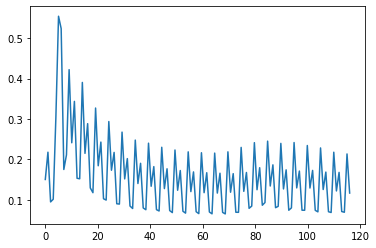

In [136]:
 print(len(train_losses))
iter = np.linspace(0,len(train_losses),len(train_losses))
plt.plot(iter,train_losses)
plt.show()


**Training the regression, skip these blocks for now**

In [ ]:
MS_criterion= MultiScale(model)
EPE_l,MS_l,REC_l=1.5,15,1

#the function below is very messy atm, im just happy that it works, it needs to be cleaned up though
#it just converts and reshapes tensors to numpy arrays and vica versa during training for the recreational loss

#creates the recreation loss, unwarps image and compares with the original image
def rec_loss(output_train,x_train,x_train_orig):
    output_np = output_train.cpu()
    #print(output_np.shape)
    
    #get shapes of output and convert/reshape into np array
    with torch.no_grad():
      output_np = np.array(output_np)  
    shape = output_np.shape
    output_np =np.reshape(output_np,(shape[0],shape[2],shape[3],shape[1]))
    

    #get shapes of x_train and convert/reshape into np array
    x_train_np = x_train.detach().cpu().numpy()
    shape2 =x_train_np.shape
    x_train_np =np.reshape(x_train_np,(shape2[0],shape2[2],shape2[3],shape2[1]))


    #print(x_train_np.shape,type(x_train_np))
    x_warped=[]
    #undo the warps using prediction flow field and manipulated image
    for i in range(train_size):
      x_warped.append(warp(x_train_np[i],output_np[i]))
    #convert from torch to numpy and reshape
    x_warped = np.array(x_warped)
    shape_warp = x_warped.shape

    #get unwarped image and turn it into torch format
    x_warped = np.reshape(x_warped,(shape_warp[0],shape_warp[3],shape_warp[1],shape_warp[2]))
    x_warp_tens = torch.from_numpy(x_warped).float()
    #turn it into cuda tensor
    if torch.cuda.is_available():
      x_warp_tens = x_warp_tens.cuda()
    #return the norm of the warped image-original image as the loss
    return torch.norm(x_warp_tens-x_train_orig,p=2,dim=1).mean()



def train_regress(epoch,EPE_l,MS_l,REC_l):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_train_orig=Variable(train_x_orig)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_train_orig=x_train_orig.cuda()  
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    print("output train shape",output_train.shape)
    print(output_train)
    total = train_size
    # computing the training and validation loss
    #print(x_train.shape)
    #print(output_train.shape)
    print("y train shape",y_train.shape)
    print(y_train)
    REC_loss = rec_loss(output_train,x_train,x_train_orig)
    EPE_loss_train = EPE(output_train,y_train.float())
    MS_loss_train,_ = MS_criterion(output_train, y_train.float())
    
    loss_train=EPE_l*EPE_loss_train+MS_l*MS_loss_train +REC_l*REC_loss 
    train_losses.append(loss_train)
    
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :',loss_train.item(),"accuracy: ")
        print("epe: ",EPE_loss_train.item()," MS: ",MS_loss_train.item()," reconstruct: ",REC_loss.item())
        print("\n")

In [ ]:
n_epochs = 500
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(model.parameters(),lr=0.0001,betas =(0.9,0.999)) 
for epoch in range(n_epochs): 
    train_regress(epoch,EPE_l,MS_l,REC_l)

TypeError: ignored

In [137]:
#function to
def get_heatmap_cv(img, magn, max_flow_mag):
    min_flow_mag = .5
    cv_magn = np.clip(
        255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),
        a_min=0,
        a_max=255).astype(np.uint8)
    if img.dtype != np.uint8:
        img = (255 * img).astype(np.uint8)
        
    heatmap_img = cv2.applyColorMap(cv_magn, cv2.COLORMAP_MAGMA)
    heatmap_img = heatmap_img[..., ::-1]
    h, w = magn.shape
    img_alpha = np.ones((h, w), dtype=np.double)[:, :, None]
    heatmap_alpha = np.clip(
        magn / max_flow_mag, a_min=0, a_max=1)[:, :, None]**.7
    heatmap_alpha[heatmap_alpha < .2]**.5
    pm_hm = heatmap_img * heatmap_alpha
    pm_img = img * img_alpha
    cv_out = pm_hm + pm_img * (1 - heatmap_alpha)
    cv_out = np.clip(cv_out, a_min=0, a_max=255).astype(np.uint8)
    return cv_out

def save_heatmap_cv(img, magn, path, max_flow_mag=2):
    cv_out = get_heatmap_cv(img, magn, max_flow_mag)
    out = Image.fromarray(cv_out)
    plt.imshow(out)
    plt.show()
    out.save(path, quality=95)
    return out

In [138]:
from utils.tools import *
from utils.visualize import *


import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

In [139]:
#quick sanity check again

#print(flow.shape)
#print(pic.size)

**uses training image to predict the flow field**

In [143]:
test_ref = X_ref[2]
test_mod = X_mod[2]
ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
image = np.array([test_mod])

shapes = image.shape

image = np.reshape(image,(shapes[0],shapes[3],shapes[1],shapes[2]))
image_tensor = torch.from_numpy(image)
image_tensor= Variable(image_tensor)
# converting the data into GPU format
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
with torch.no_grad():
        flow = perPix_model(image_tensor.float()).float().cpu()
        print(flow.shape)
        flow = torch.argmax(flow,dim =1).numpy()
        flow = np.reshape(flow,(shapes[1],shapes[2]))
        
        print(flow)
        real_flow = np.zeros((2,400,400))
        temp =0
        for i in range(shapes[1]):
          for j in range(shapes[2]):
            real_flow[:,i,j]=list(dic.keys())[list(dic.values()).index(flow[i][j])]
        print(real_flow.shape)
        np.set_printoptions(edgeitems=3)
        #print(real_flow)
        real_flow = np.transpose(real_flow, (1, 2, 0))
        print(real_flow.shape)
        #print(real_flow)
        w, h, _ = real_flow.shape

torch.Size([1, 121, 400, 400])
[[60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]
 ...
 [60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]
 [60 60 60 ... 60 60 60]]
(2, 400, 400)
(400, 400, 2)


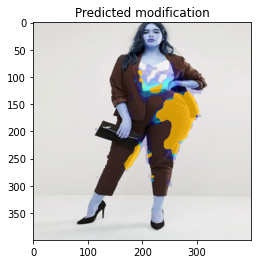

In [144]:
image = np.reshape(image,(h,w,3))
image = Image.fromarray(image,"RGB")
modified = image.resize((h, w),Image.BICUBIC)
modified_np = np.asarray(modified)
flow = flow_resize(real_flow, modified.size)
#print(flow.shape)
mag, ang = cv2.cartToPolar(flow[...,1], flow[...,0])
#print(mag.shape)
#print(modified_np.shape)
#save your image to the folder
path = "tester.png"
tester =get_heatmap_cv(modified_np,mag,max_flow_mag=10)
plt.title("Predicted modification")
plt.imshow(tester)

**plots the ground truth heatmap on the image**

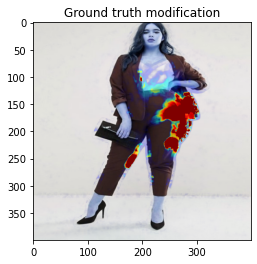

In [145]:

mag, ang = cv2.cartToPolar(ground_flow[...,0], ground_flow[...,1])
#print(mag.shape)
real = get_heatmap_cv(modified_np,mag,max_flow_mag=12)
plt.title("Ground truth modification")
plt.imshow(real)

In [ ]:
~